In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from tqdm import tqdm
import wandb
from PIL import Image

In [2]:
# Initialize Weights & Biases (wandb)
wandb.init(project="agco-anomaly-classification", entity="sameerhashmi1995")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sameerhashmi1995. Use `wandb login --relogin` to force relogin


In [3]:
class CustomImageDataset(Dataset):
    """
    Custom dataset class for loading images from root directory.
    It reads images from 'good' and 'synthetic_anomalous' folders and assigns labels accordingly.
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []
        self.classes = {'good': 0, 'synthetic_anomalous': 1}

        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                for img_file in os.listdir(label_path):
                    img_path = os.path.join(label_path, img_file)
                    self.data.append(img_path)
                    self.labels.append(self.classes[label])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        
        # Use PIL to open the image and convert to RGB to ensure 3 channels
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

In [4]:
from collections import defaultdict

# Initialize the dataset
root_dir = "./datasets/mvtec_with_synthetic_anomalous/leather_normal"
transform = None 
dataset = CustomImageDataset(root_dir=root_dir, transform=transform)

# Dictionary to store shapes for each class
shapes_by_class = defaultdict(list)

# Iterate through the dataset and record the shapes
for image, label in dataset:
    image = np.array(image)
    shapes_by_class[label].append(image.shape)

# Print the shapes of images for each class
for label, shapes in shapes_by_class.items():
    print(f"Class {label}:")
    for i, shape in enumerate(shapes[:5]):  # Display up to the first 5 shapes for brevity
        print(f"  Image {i} shape: {shape}")
    print(f"  Total images in class {label}: {len(shapes)}\n")

Class 1:
  Image 0 shape: (256, 256, 3)
  Image 1 shape: (256, 256, 3)
  Image 2 shape: (256, 256, 3)
  Image 3 shape: (256, 256, 3)
  Image 4 shape: (256, 256, 3)
  Total images in class 1: 389

Class 0:
  Image 0 shape: (1024, 1024, 3)
  Image 1 shape: (1024, 1024, 3)
  Image 2 shape: (1024, 1024, 3)
  Image 3 shape: (1024, 1024, 3)
  Image 4 shape: (1024, 1024, 3)
  Total images in class 0: 245



In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(20),      # Rotate the images randomly
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Add color jittering
    transforms.ToTensor(),
])


In [6]:
dataset = CustomImageDataset(root_dir='./datasets/mvtec_with_synthetic_anomalous/leather_normal', transform=transform)

In [8]:
(dataset[0])

(tensor([[[0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          ...,
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392]],
 
         [[0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          ...,
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392]],
 
         [[0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392,  ...,

In [9]:
dataset_size = len(dataset)
train_size = int(0.80 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [10]:
good_count = sum(1 for label in dataset.labels if label == 0)
anomalous_count = len(dataset) - good_count

In [11]:
print(f'Good: {good_count}, Anomalous: {anomalous_count}')
print("Train dataset length: ",len(train_dataset), ", Val dataset length: ", len(val_dataset))

Good: 245, Anomalous: 389
Train dataset length:  507 , Val dataset length:  127


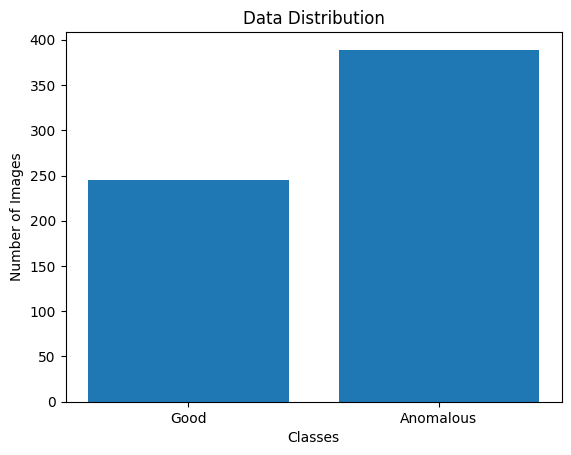

In [12]:
# Visualizing data distribution

plt.bar(['Good', 'Anomalous'], [good_count, anomalous_count])
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Data Distribution')
plt.show()

In [13]:
# Calculating Mean and Standard Deviation
loader = DataLoader(dataset, batch_size=64, shuffle=False)
mean = torch.zeros(3).to('cuda')
std = torch.zeros(3).to('cuda')
nb_samples = 0

In [14]:
for data, _ in loader:
    data = data.to('cuda')
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

In [15]:
mean /= nb_samples
std /= nb_samples
print(f'Mean: {mean}, Std: {std}')

Mean: tensor([0.3614, 0.2410, 0.2010], device='cuda:0'), Std: tensor([0.1036, 0.0684, 0.0550], device='cuda:0')


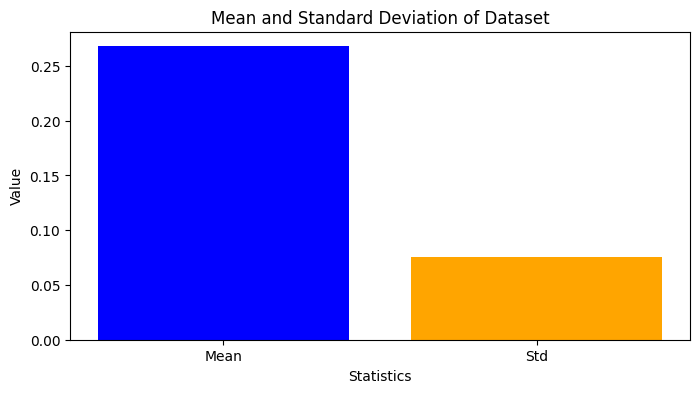

In [16]:
plt.figure(figsize=(8, 4))
plt.bar(['Mean', 'Std'], [mean.mean().item(), std.mean().item()], color=['blue', 'orange'])
plt.xlabel('Statistics')
plt.ylabel('Value')
plt.title('Mean and Standard Deviation of Dataset')
plt.show()

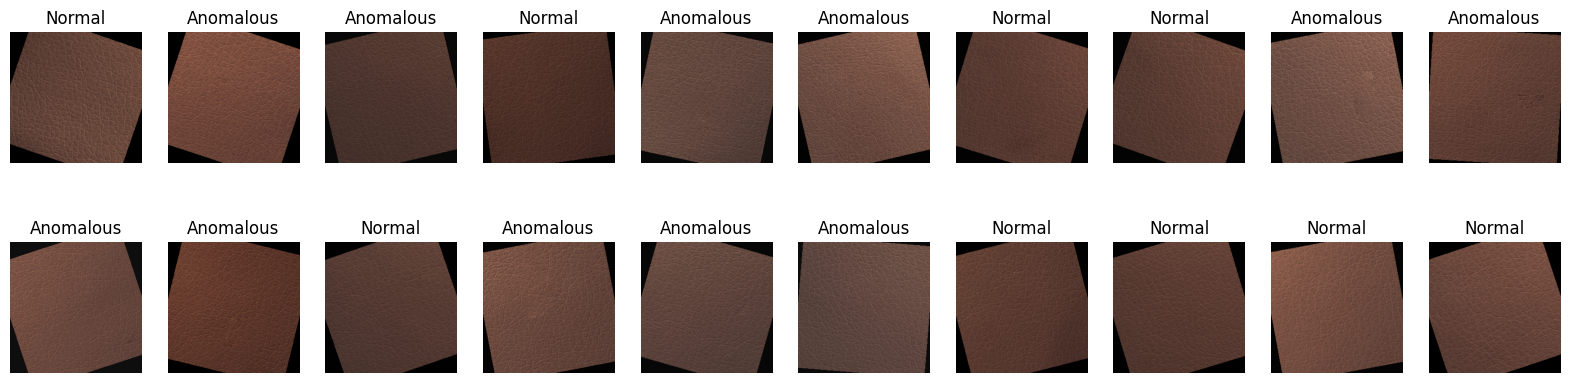

In [17]:
# Visualizing some data

plt.figure(figsize=(20, 5))
for i in range(20):
    idx = torch.randint(0, len(dataset), (1,)).item()
    image, label = dataset[idx]
    plt.subplot(2, 10, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title('Normal' if label == 0 else 'Anomalous')
    plt.axis('off')
plt.show()

In [18]:
class ResNet18(nn.Module):
    """
    Custom ResNet18 model for binary classification (Good vs Synthetic_anomalous).
    """
    def __init__(self):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)  # 2 classes (Good, Synthetic_anomalous)

    def forward(self, x):
        return self.model(x)

In [19]:
def train_model(model, criterion, optimizer, dataloader, device):
    """
    Function to train the model for one epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = 100 * correct / total
    wandb.log({"Train Loss": epoch_loss, "Train Accuracy": accuracy})
    return epoch_loss, accuracy

In [20]:
def validate_model(model, criterion, dataloader, device):
    """
    Function to validate the model after each epoch.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = 100 * correct / total
    wandb.log({"Validation Loss": epoch_loss, "Validation Accuracy": accuracy})
    return epoch_loss, accuracy

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18().to(device)
class_weights = torch.tensor([1.0, float(good_count) / anomalous_count]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [23]:
num_epochs = 10

best_val_acc = 0.0  # Initialize the best validation accuracy

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, criterion, optimizer, train_loader, device)
    val_loss, val_acc = validate_model(model, criterion, val_loader, device)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Save model if validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f'./mvtec_classification_weights_normal_leather/best_model.pth')
        print(f'Model saved at epoch {epoch+1} with validation accuracy: {val_acc:.2f}%')

Epoch [1/10], Train Loss: 0.1279, Train Acc: 96.06%, Val Loss: 2.7815, Val Acc: 38.58%
Model saved at epoch 1 with validation accuracy: 38.58%


Epoch [2/10], Train Loss: 0.0034, Train Acc: 100.00%, Val Loss: 0.0082, Val Acc: 100.00%
Model saved at epoch 2 with validation accuracy: 100.00%


Epoch [3/10], Train Loss: 0.0017, Train Acc: 100.00%, Val Loss: 0.0001, Val Acc: 100.00%


Epoch [4/10], Train Loss: 0.0093, Train Acc: 99.80%, Val Loss: 0.1093, Val Acc: 98.43%


Epoch [5/10], Train Loss: 0.0250, Train Acc: 99.21%, Val Loss: 0.3161, Val Acc: 91.34%


Epoch [6/10], Train Loss: 0.0174, Train Acc: 99.41%, Val Loss: 0.0933, Val Acc: 96.06%


Epoch [7/10], Train Loss: 0.0054, Train Acc: 99.80%, Val Loss: 0.0002, Val Acc: 100.00%
Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.


Epoch [8/10], Train Loss: 0.0077, Train Acc: 99.61%, Val Loss: 0.0045, Val Acc: 100.00%


Epoch [9/10], Train Loss: 0.0012, Train Acc: 100.00%, Val Loss: 0.0001, Val Acc: 100.00%


Epoch [10/10], Train Loss: 0.0006, Train Acc: 100.00%, Val Loss: 0.0001, Val Acc: 100.00%


### Testing

In [36]:
class LeatherTestDataset(Dataset):
    """
    Custom dataset for loading test images from 'Leather/test' directory.
    
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []
        
        # Define label names based on folder names
        self.classes = {'good': 'good', 'color': 'synthetic_anomalous', 'cut': 'synthetic_anomalous', 'hole': 'synthetic_anomalous', 'metal_contamination': 'synthetic_anomalous', 'thread': 'synthetic_anomalous'}

        # Loop through each folder and assign labels accordingly
        for label_name, label in self.classes.items():
            folder_path = os.path.join(root_dir, label_name)
            if os.path.isdir(folder_path):
                for img_file in os.listdir(folder_path):
                    img_path = os.path.join(folder_path, img_file)
                    self.data.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path).convert('RGB')  # Convert to RGB to ensure 3 channels
        label = self.labels[idx]
        
        # Apply transformations, if provided
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [37]:
# Load the model checkpoint
model = ResNet18()
model.load_state_dict(torch.load('./mvtec_classification_weights_normal_leather/best_model.pth'))
model.to(device)

/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [38]:
# Map text labels to numerical values for testing
label_mapping = {"good": 0, "synthetic_anomalous": 1}

In [39]:
def test_model(model, dataloader, device):
    """
    Function to test the model on the test dataset.
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing", leave=False):
            images = images.to(device)
            
            # Convert string labels to numerical values using the mapping
            labels = torch.tensor([label_mapping[label] for label in labels]).to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    return y_true, y_pred

In [40]:
# Create an instance of the dataset
test_dataset = LeatherTestDataset(root_dir="./datasets/mvtec/leather/test/", transform=transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [41]:
y_true, y_pred = test_model(model, test_loader, device)

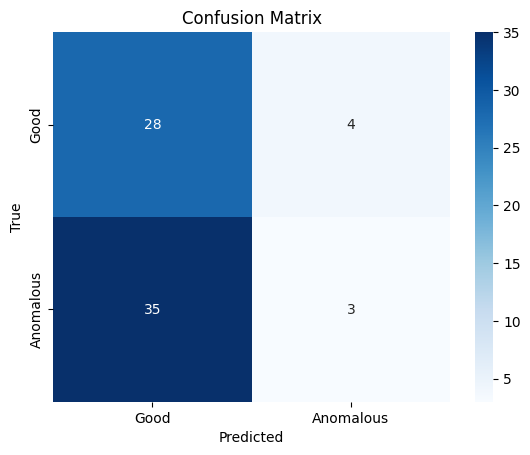

In [42]:
# Plotting Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Good', 'Anomalous'], yticklabels=['Good', 'Anomalous'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [44]:
# Calculating Precision, Recall, and F1 Score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

Precision: 0.4286, Recall: 0.0789, F1 Score: 0.1333


In [45]:
# Logging metrics to wandb
wandb.log({"Precision": precision, "Recall": recall, "F1 Score": f1})

In [46]:
def visualize_examples(y_true, y_pred, dataset):
    """
    Function to visualize True Positives, True Negatives, False Positives, and False Negatives.
    """
    tp_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t == p == 1]
    tn_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t == p == 0]
    fp_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t == 0 and p == 1]
    fn_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t == 1 and p == 0]

    indices = {
        'True Positive': tp_indices,
        'True Negative': tn_indices,
        'False Positive': fp_indices,
        'False Negative': fn_indices
    }

    # Plot some examples from each category
    plt.figure(figsize=(20, 10))
    for i, (label, idx_list) in enumerate(indices.items()):
        if len(idx_list) > 0:
            idx = idx_list[0]  # Visualize the first example of each type
            image, true_label = dataset[idx]
            predicted_label = "good" if y_pred[idx] == 0 else "synthetic_anomalous"
            plt.subplot(2, 4, i + 1)
            plt.imshow(image.permute(1, 2, 0))
            plt.title(f'{label}\nTrue: {"good" if true_label == 0 else "synthetic_anomalous"} | Pred: {predicted_label}')
            plt.axis('off')
    plt.show()


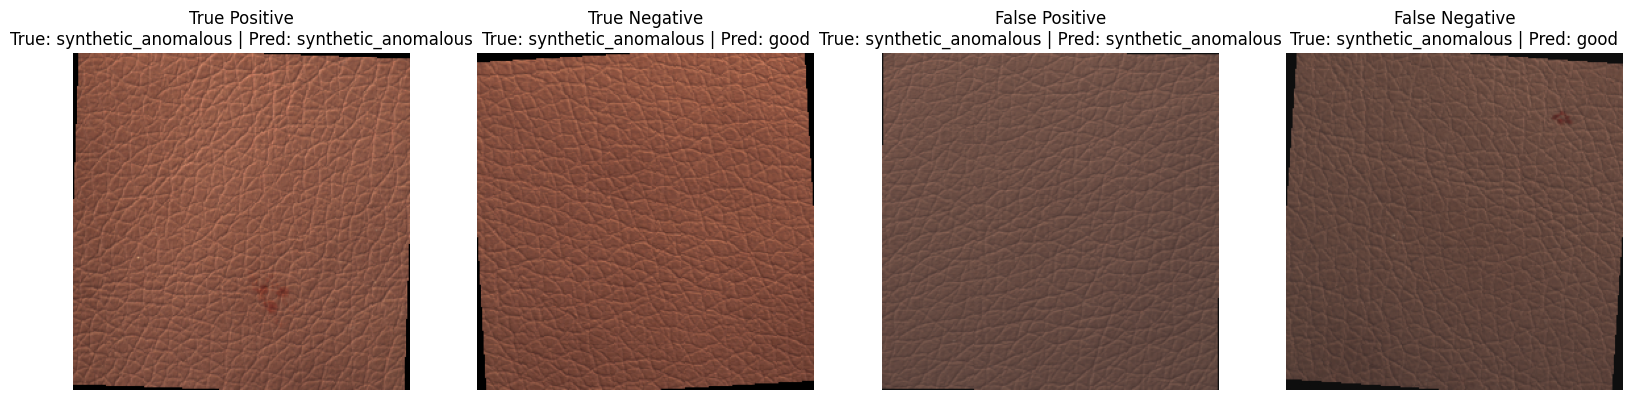

In [47]:
visualize_examples(y_true, y_pred, test_dataset)